# Subjectivity in News Articles

## Group:
- Luca Babboni - luca.babboni2@studio.unibo.it
- Matteo Fasulo - matteo.fasulo@studio.unibo.it
- Luca Tedeschini - luca.tedeschini3@studio.unibo.it

## Description

This notebook addresses Task 1 proposed in [CheckThat Lab](https://checkthat.gitlab.io/clef2025/) of CLEF 2025. In this task, systems are challenged to distinguish whether a sentence from a news article expresses the subjective view of the author behind it or presents an objective view on the covered topic instead.

This is a binary classification tasks in which systems have to identify whether a text sequence (a sentence or a paragraph) is subjective (SUBJ) or objective (OBJ).

The task comprises three settings:

* Monolingual: train and test on data in a given language
* Multilingual: train and test on data comprising several languages
* Zero-shot: train on several languages and test on unseen languages

training data in five languages:
* Arabic
* Bulgarian
* English
* German
* Italian

The official evaluation is macro-averaged F1 between the two classes.

In [36]:
from collections import defaultdict
import os
import gc
from pathlib import Path

import csv

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm import tqdm

from joblib import delayed, Parallel

from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, RandomSampler, TensorDataset

from sentence_transformers import SentenceTransformer
from datasets import Dataset
from huggingface_hub import notebook_login
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding, RobertaTokenizerFast, RobertaForSequenceClassification, pipeline, AdamW, get_linear_schedule_with_warmup

In [2]:
SEED = 42
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [3]:
np.random.seed(SEED)
tf.random.set_seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [4]:
data_folder = '/kaggle/input/clef2025-checkthat/data' # data
dataset = pd.DataFrame(columns=['sentence_id','sentence','label','lang','split'])

for language in os.listdir(data_folder):
    for filename in os.listdir(f"{data_folder}{os.sep}{language}"):
        if '.tsv' in filename:
            abs_path = f"{data_folder}{os.sep}{language}{os.sep}{filename}"
            df = pd.read_csv(abs_path, sep='\t', quoting=csv.QUOTE_NONE)
            if 'solved_conflict' in df.columns:
                df.drop(columns=['solved_conflict'], inplace=True)
            df['lang'] = language
            df['split'] = Path(filename).stem
            dataset = pd.concat([dataset, df], axis=0)

In [5]:
train = dataset[dataset['split'].str.contains('train')].copy()
dev = dataset[dataset['split'].str.contains('dev')].copy()
test = dataset[dataset['split'].str.contains('dev_test')].copy()

print(f"Train: {train.shape}")
print(f"Dev: {dev.shape}")
print(f"Test: {test.shape}")

Train: (6418, 5)
Dev: (4733, 5)
Test: (2332, 5)


In [6]:
print(f"Train: {train['label'].value_counts(normalize=True)}")
print(f"Dev: {dev['label'].value_counts(normalize=True)}")
print(f"Test: {test['label'].value_counts(normalize=True)}")

Train: label
OBJ     0.631349
SUBJ    0.368651
Name: proportion, dtype: float64
Dev: label
OBJ     0.634481
SUBJ    0.365519
Name: proportion, dtype: float64
Test: label
OBJ     0.657376
SUBJ    0.342624
Name: proportion, dtype: float64


Legend:
* Objective -> 0
* Subjective -> 1

In [7]:
train.loc[:, 'label'] = train['label'].apply(lambda x: 0 if x == 'OBJ' else 1)
dev.loc[:, 'label'] = dev['label'].apply(lambda x: 0 if x == 'OBJ' else 1)
test.loc[:, 'label'] = test['label'].apply(lambda x: 0 if x == 'OBJ' else 1)

In [8]:
train['label'] = train['label'].astype(int)
dev['label'] = dev['label'].astype(int)
test['label'] = test['label'].astype(int)

In [16]:
#notebook_login()

# Baseline Model

In [24]:
vect = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [31]:
model = LogisticRegression(class_weight="balanced", solver='saga', random_state=SEED)
model.fit(X=vect.encode(train['sentence'].values), y=train['label'].values)

Batches:   0%|          | 0/201 [00:00<?, ?it/s]

LogisticRegression(class_weight='balanced', random_state=42, solver='saga')

In [32]:
predictions = model.predict(X=vect.encode(test['sentence'].values)).tolist()

Batches:   0%|          | 0/73 [00:00<?, ?it/s]

In [33]:
pred_df = pd.DataFrame()
pred_df['sentence_id'] = test['sentence_id']
pred_df['label'] = predictions

In [34]:
def evaluate_model(gold_values, predicted_values):
    acc = accuracy_score(gold_values, predicted_values)
    m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(gold_values, predicted_values, average="macro",
                                                               zero_division=0)
    p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(gold_values, predicted_values, labels=[1],
                                                               zero_division=0)

    return {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

In [35]:
evaluate_model(gold_values=test.label.values, predicted_values=predictions)

{'macro_F1': 0.6220011992495018,
 'macro_P': 0.6223227143343395,
 'macro_R': 0.633496534725811,
 'SUBJ_F1': 0.538037486218302,
 'SUBJ_P': 0.4807881773399015,
 'SUBJ_R': 0.6107634543178974,
 'accuracy': 0.6406518010291595}

In [50]:
torch.cuda.empty_cache()

del model

gc.collect()

65

# ModernBERT-base

In [10]:
model_card = "microsoft/mdeberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_card, use_Fast=False)
model = AutoModelForSequenceClassification.from_pretrained(
    model_card, 
    num_labels=2, 
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
model.cuda()

DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(251000, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): Dropout(p=0.1, inplace=False)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

In [12]:
model.resize_token_embeddings(len(tokenizer))

Embedding(250102, 768, padding_idx=0)

In [19]:
def tokenize_text(sentences: pd.Series, max_length: int = 40):
    input_ids = []
    attention_masks = []
    for sent in tqdm(sentences, desc='Tokenize of sentences'):
        encoded = tokenizer.encode_plus(
            sent,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask = True,
            return_tensors = 'pt')

        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    return input_ids, attention_masks

def create_dataloader(input_ids, attention_masks, labels, batch_size):
    dataset = TensorDataset(input_ids, attention_masks, labels)
    return DataLoader(dataset, sampler=RandomSampler(dataset), batch_size=batch_size)

In [21]:
train_input_ids, train_attention_masks = tokenize_text(train['sentence'].to_list())
dev_input_ids, dev_attention_masks = tokenize_text(dev['sentence'].to_list())

Tokenize of sentences: 100%|██████████| 4733/4733 [00:01<00:00, 2578.90it/s]


In [40]:
epochs = 5
train_dl = create_dataloader(train_input_ids, train_attention_masks, torch.Tensor(train['label'].values), batch_size=32)
dev_dl = create_dataloader(dev_input_ids, dev_attention_masks, torch.Tensor(dev['label'].values), batch_size=32)
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=1e-1)
total_steps = len(train_dl) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=200, num_training_steps=total_steps)

In [48]:
for i, epoch in enumerate(range(epochs), start=1):
    print(f"======== Epoch {i} / {epochs} ========")
    print('Training...')

    total_train_loss = 0
    model.train()

    for step, batch in tqdm(enumerate(train_dl)):
        b_input_ids, b_input_mask, b_labels = batch
        b_input_ids = b_input_ids.to(device)
        b_input_mask = b_input_mask.to(device)
        b_labels = b_labels.to(device)

        model.zero_grad()

        result = model(b_input_ids,
          attention_mask=b_input_mask,
          labels=b_labels,
          return_dict=True)

        loss = result.loss
        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
    avg_train_loss = total_train_loss / len(train_dl)

    print(f"Average training loss: {avg_train_loss:.3f}")
          
    print("Running Validation...")

    model.eval()

    total_eval_loss = 0

    for batch in tqdm(dev_dl, desc="Validation set"):
        b_input_ids, b_input_mask, b_labels = batch
        b_input_ids = b_input_ids.to(device)
        b_input_mask = b_input_mask.to(device)
        b_labels = b_labels.to(device)

        with torch.no_grad():
            result = model(b_input_ids,
                          token_type_ids=None,
                          attention_mask=b_input_mask,
                          labels=b_labels,
                          return_dict=True)

        loss = result.loss
        logits = result.logits

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        true_labels[i].append(label_ids)
        predictions[i].append(logits)

    # Printing the cr
    flat_predictions = np.concatenate(predictions, axis=0)
    flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
    flat_true_labels = np.concatenate(labels, axis=0)
    
    stats = evaluate_model(flat_true_labels, flat_predictions)

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(dev_dl)
    val_losses[i] = avg_val_loss
    print("  Validation Loss: {0:.3f}".format(avg_val_loss))

    training_stats.append(stats)

======== Epoch 1 / 5 ========
Training...


201it [00:43,  4.60it/s]


Average training loss: 0.348
Running Validation...


Validation set: 100%|██████████| 148/148 [00:08<00:00, 18.19it/s]


TypeError: The first input argument needs to be a sequence

In [49]:
predictions

defaultdict(list,
            {1: [array([[-1.6144705 ,  2.1010613 ],
                     [ 0.07395864,  0.08639809],
                     [ 0.02335688,  0.15558362],
                     [ 0.2367228 , -0.08481967],
                     [ 0.5077632 , -0.52410686],
                     [ 2.876152  , -2.6373587 ],
                     [ 1.8095766 , -2.057451  ],
                     [ 2.6735823 , -2.5953143 ],
                     [-0.27734035,  0.29390147],
                     [ 1.712161  , -1.8517125 ],
                     [ 0.9728497 , -0.8659263 ],
                     [ 2.308594  , -2.2167835 ],
                     [ 2.9121528 , -2.6749043 ],
                     [-0.21939887,  0.44238853],
                     [-1.7956576 ,  2.314026  ],
                     [ 0.54808897, -0.72181445],
                     [ 2.4020133 , -2.3601677 ],
                     [ 2.6935735 , -2.5357506 ],
                     [ 0.10139138,  0.06796902],
                     [ 2.9000218 , -2.674025  ],

In [14]:
# Taken from https://github.com/huggingface/transformers/blob/main/src/transformers/trainer.py#L3700 (with some minor changes removing useless parts)
class CustomTrainer(Trainer):
    def __init__(self, class_weights, device, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # You pass the class weights when instantiating the Trainer
        self.class_weights = class_weights
        self.device = device

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        if self.label_smoother is not None and "labels" in inputs:
            labels = inputs.pop("labels")
        else:
            labels = None
        outputs = model(**inputs)
        if self.args.past_index >= 0:
            self._past = outputs[self.args.past_index]

        if labels is not None:
            loss = self.label_smoother(outputs, labels)
        else:
            # We extract the logits from the model outputs
            logits = outputs.get('logits')
            # We compute the loss manually passing the class weights to the loss function
            criterion = torch.nn.CrossEntropyLoss(weight=self.class_weights.to(self.device)) # Modified to use the class weights
            # We compute the loss using the modified criterion
            loss = criterion(logits, inputs['labels'])

        return (loss, outputs) if return_outputs else loss

In [15]:
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(train['label']), y=train['label'])
class_weights = torch.tensor(class_weights, dtype=torch.float32)
class_weights

tensor([0.7920, 1.3563])

In [16]:
def compute_metrics(output_info):
    """
    Compute various evaluation metrics for model predictions.
    
    Args:
        output_info (tuple): A tuple containing the model predictions and the true labels.
            - predictions (np.ndarray): The predicted labels from the model.
            - labels (np.ndarray): The true labels.
    
    Returns:
        dict: A dictionary containing the computed metrics:
            - 'f1': The F1 score (macro average).
            - 'accuracy': The accuracy score.
            - 'precision': The precision score (macro average).
            - 'recall': The recall score (macro average).
    """
    predictions, labels = output_info
    predictions = np.array(predictions)
    labels = np.array(labels)
    predictions = np.argmax(predictions, axis=-1)
    
    f1 = f1_score(labels, predictions, average="macro", zero_division=0)
    acc = accuracy_score(labels, predictions)
    
    return {"f1" : f1, "accuracy" : acc}

In [17]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dl,
    eval_dataset=dev_dl,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    class_weights=class_weights,
    device=device,
)

In [18]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.588500,0.677161,0.674505,0.676315
2,0.506300,0.573425,0.706160,0.740968
3,0.445300,0.678541,0.709967,0.742658
4,0.383000,0.718300,0.711703,0.747940
5,0.326700,0.753619,0.706157,0.739277


TrainOutput(global_step=1005, training_loss=0.4556496041331125, metrics={'train_runtime': 953.5422, 'train_samples_per_second': 33.653, 'train_steps_per_second': 1.054, 'total_flos': 2868856118589840.0, 'train_loss': 0.4556496041331125, 'epoch': 5.0})

Map:   0%|          | 0/748 [00:00<?, ? examples/s]

Prediction of language: arabic
F1 Macro: 0.5032807159698065


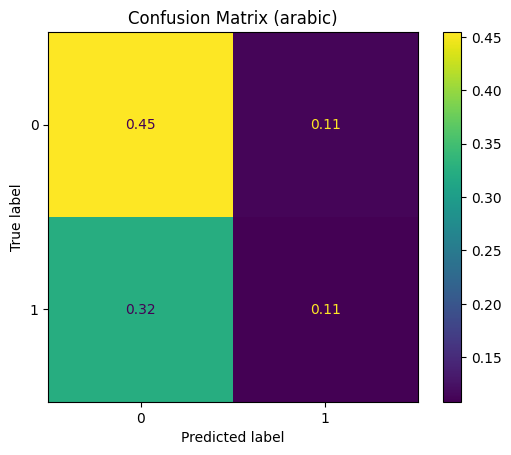

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Prediction of language: bulgarian
F1 Macro: 0.7919216646266829


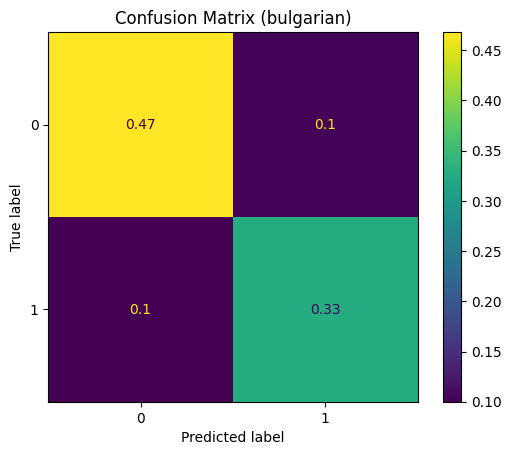

Map:   0%|          | 0/484 [00:00<?, ? examples/s]

Prediction of language: english
F1 Macro: 0.7506721949993718


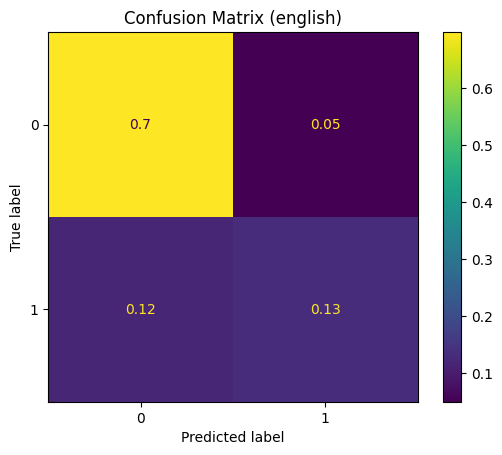

Map:   0%|          | 0/337 [00:00<?, ? examples/s]

Prediction of language: german
F1 Macro: 0.8827220029232499


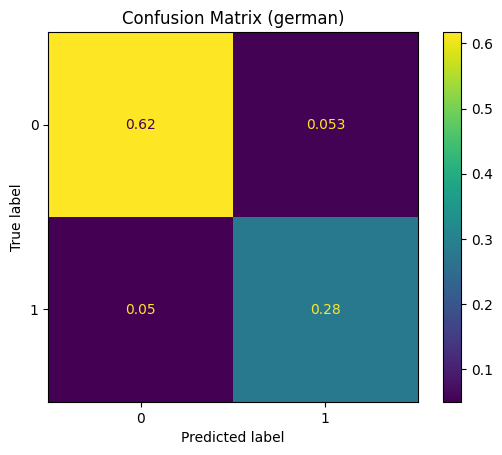

Map:   0%|          | 0/513 [00:00<?, ? examples/s]

Prediction of language: italian
F1 Macro: 0.7340803062323059


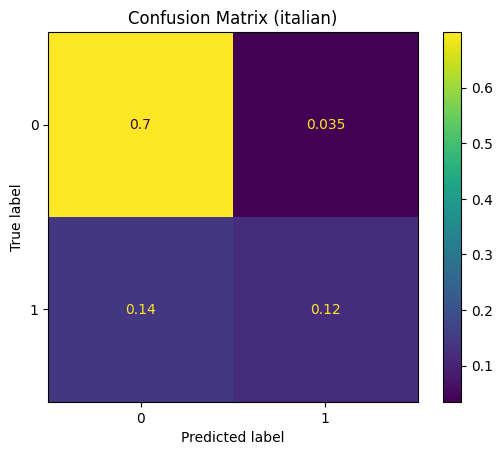

In [21]:
results_df = pd.DataFrame(columns=['model','f1','acc','lang'])

for language in test['lang'].unique():
    test_dl = Dataset.from_pandas(test[test['lang'] == language])
    test_dl = test_dl.map(preprocess_text, batched=True)
    predictions, labels, _ = trainer.predict(test_dl)
    predictions = np.argmax(predictions, axis=1)
    f1_macro = f1_score(labels, predictions, average="macro", zero_division=0)
    acc = accuracy_score(labels, predictions)

    results_df.loc[len(results_df)] = [model_card, f1_macro, acc, language]

    print("Prediction of language:", language)
    print("F1 Macro:", f1_score(labels, predictions, average="macro", zero_division=0))
    
    ConfusionMatrixDisplay.from_predictions(labels, predictions, normalize='all')
    plt.title(f"Confusion Matrix ({language})")
    plt.show()

In [22]:
results_df

,model,f1,acc,lang
0,microsoft/mdeberta-v3-base,0.503281,0.562834,arabic
1,microsoft/mdeberta-v3-base,0.791922,0.796000,bulgarian
2,microsoft/mdeberta-v3-base,0.750672,0.830579,english
3,microsoft/mdeberta-v3-base,0.882722,0.896142,german
4,microsoft/mdeberta-v3-base,0.734080,0.822612,italian


# Emotions

In [ ]:
model_card = "arpanghoshal/EmoRoBERTa"
tokenizer = RobertaTokenizerFast.from_pretrained(model_card)
model = RobertaForSequenceClassification.from_pretrained(model_card, from_tf=True)

In [ ]:
emotion = pipeline('sentiment-analysis', model='arpanghoshal/EmoRoBERTa', return_all_scores= True)

In [ ]:
# Example
print(train_data.iloc[0]['sentence'], train_data.iloc[0]['label'])
emotion_labels = emotion(train_data.iloc[0]['sentence'])
pd.DataFrame(emotion_labels[0]).sort_values(by='score', ascending=False)

In [ ]:
emotion_array = np.zeros((train_data.shape[0], 28))

for i, sentence in enumerate(tqdm(train_data['sentence'])):
    result = emotion(sentence)[0]
    emotion_array[i] = np.array([list(d.values())[1] for d in result])

In [ ]:
emotion_df_train = pd.DataFrame(emotion_array, columns=[list(d.values())[0] for d in result])
emotion_df_train.head()

In [ ]:
train_data_augmented = pd.concat([train_data, emotion_df_train], axis=1)
train_data_augmented.head()

In [ ]:
emotion_array = np.zeros((test_data.shape[0], 28))

for i, sentence in enumerate(tqdm(test_data['sentence'])):
    result = emotion(sentence)[0]
    emotion_array[i] = np.array([list(d.values())[1] for d in result])

In [ ]:
emotion_df_test = pd.DataFrame(emotion_array, columns=[list(d.values())[0] for d in result])
emotion_df_test.head()

In [ ]:
test_data_augmented = pd.concat([test_data, emotion_df_test], axis=1)
test_data_augmented.head()

In [ ]:
if not os.path.exists('/kaggle/input/clef2025-checkthat/data/english/train_en_aug.csv'):
    train_data_augmented.to_csv('train_en_aug.csv', encoding='UTF-8')
    test_data_augmented.to_csv('dev_test_en_aug.csv', encoding='UTF-8')
else:
    train_data_augmented = pd.read_csv('/kaggle/input/clef2025-checkthat/data/english/train_en_aug.csv', encoding='UTF-8', index_col=0)
    test_data_augmented = pd.read_csv('/kaggle/input/clef2025-checkthat/data/english/dev_test_en_aug.csv', encoding='UTF-8', index_col=0)

In [ ]:
def preprocess(text):
    preprocessed_text = []
    for t in text.split():
        if len(t) > 1:
            t = '@user' if t[0] == '@' and t.count('@') == 1 else t
            t = 'http' if t.startswith('http') else t
        preprocessed_text.append(t)
    return ' '.join(preprocessed_text)

In [ ]:
# Taken from https://github.com/huggingface/transformers/blob/main/src/transformers/trainer.py#L3700 (with some minor changes removing useless parts)
class CustomTrainer(Trainer):
    def __init__(self, class_weights, device, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # You pass the class weights when instantiating the Trainer
        self.class_weights = class_weights
        self.device = device

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        if self.label_smoother is not None and "labels" in inputs:
            labels = inputs.pop("labels")
        else:
            labels = None
        outputs = model(**inputs)
        if self.args.past_index >= 0:
            self._past = outputs[self.args.past_index]

        if labels is not None:
            loss = self.label_smoother(outputs, labels)
        else:
            # We extract the logits from the model outputs
            logits = outputs.logits
            # We compute the loss manually passing the class weights to the loss function
            criterion = torch.nn.CrossEntropyLoss(weight=self.class_weights.to(self.device)) # Modified to use the class weights
            # We compute the loss using the modified criterion
            loss = criterion(logits, inputs['labels'])

        return (loss, outputs) if return_outputs else loss

In [ ]:
class CustomEmotionModel(nn.Module):
    def __init__(self, model_card: str, num_labels: int, num_emotions: int, class_weights: torch.Tensor, device):
        super(CustomEmotionModel, self).__init__()
        self.base_model = AutoModel.from_pretrained(model_card)
        #self.emotion_branch = nn.Linear(num_emotions, 128)  # Example: 128 hidden units
        self.classifier = nn.Linear(self.base_model.config.hidden_size + 28, num_labels)
        self.class_weights = class_weights.to(device)

    def forward(self, input_ids, attention_mask, emotion_features, labels=None):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # CLS token representation
        
        # Process emotion features
        #emotion_output = torch.relu(self.emotion_branch(emotion_features))
        
        # Concatenate base model output with emotion features
        combined_output = torch.cat((pooled_output, emotion_features), dim=1)
        
        # Apply classification layer
        logits = self.classifier(combined_output)

        loss = None
        if labels is not None:
            criterion = torch.nn.CrossEntropyLoss(weight=self.class_weights)
            loss = criterion(logits, labels)

        return SequenceClassifierOutput(loss=loss, logits=logits)

In [ ]:
train_data_augmented['all_emotions'] = train_data_augmented[train_data_augmented.columns[-28:]].apply(lambda x: np.array(x.values, dtype=np.float32), axis=1)
test_data_augmented['all_emotions'] = test_data_augmented[test_data_augmented.columns[-28:]].apply(lambda x: np.array(x.values, dtype=np.float32), axis=1)

In [ ]:
train_dl = Dataset.from_pandas(train_data_augmented)
test_dl = Dataset.from_pandas(test_data_augmented)

In [ ]:
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(train_data['label']), y=train_data['label'])
class_weights = torch.tensor(class_weights, dtype=torch.float32)
class_weights

In [ ]:
model_card = "cardiffnlp/twitter-roberta-base-2022-154m"
tokenizer = AutoTokenizer.from_pretrained(model_card, use_Fast=False)
model = CustomEmotionModel(model_card, num_labels = 2, num_emotions=28, class_weights=class_weights, device=device)

In [ ]:
def tokenize_and_prepare(texts):
    tokenized = tokenizer(texts['sentence'])
    return {**tokenized, 'emotion_features': texts['all_emotions']}

In [ ]:
train_dl = train_dl.map(tokenize_and_prepare, batched=True)
test_dl = test_dl.map(tokenize_and_prepare, batched=True)

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

In [ ]:
training_args = TrainingArguments(
    output_dir=f'model',                 
    learning_rate=5e-6,
    per_device_train_batch_size=16,         
    per_device_eval_batch_size=16,
    lr_scheduler_type='linear',
    label_smoothing_factor=0.1,
    num_train_epochs=10,
    weight_decay=1e-2,
    eval_strategy="epoch",       
    save_strategy="no",           
    #save_safetensors=True,
    #load_best_model_at_end=True,
    report_to='none',
    seed=SEED,
    data_seed=SEED
)

In [ ]:
def compute_metrics(output_info):
    """
    Compute various evaluation metrics for model predictions.
    
    Args:
        output_info (tuple): A tuple containing the model predictions and the true labels.
            - predictions (np.ndarray): The predicted labels from the model.
            - labels (np.ndarray): The true labels.
    
    Returns:
        dict: A dictionary containing the computed metrics:
            - 'f1': The F1 score (macro average).
            - 'accuracy': The accuracy score.
            - 'precision': The precision score (macro average).
            - 'recall': The recall score (macro average).
    """
    predictions, labels = output_info
    predictions = np.array(predictions)
    labels = np.array(labels)
    predictions = np.argmax(predictions, axis=-1)
    
    f1 = f1_score(labels, predictions, average="macro", zero_division=0)
    acc = accuracy_score(labels, predictions)
    
    return {"f1-score" : f1, "Accuracy" : acc}

In [ ]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dl,
    eval_dataset=test_dl,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    class_weights=class_weights,
    device=device,
)

In [ ]:
trainer.train()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
prediction, labels, _ = trainer.predict(test_dl)
prediction = np.argmax(prediction, axis=1)
cm = confusion_matrix(y_true=labels, y_pred=prediction, normalize='all')
print(roc_auc_score(labels, prediction))

ConfusionMatrixDisplay(cm).plot()